In [ ]:
import os, cv2
import numpy as np
import pandas as pd
import random, tqdm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import albumentations as album

In [ ]:
!pip install -q -U segmentation-models-pytorch albumentations > /dev/null
import segmentation_models_pytorch as smp

In [ ]:
DATA_DIR = '../input/kvasirseg'

metadata_df = pd.read_csv(os.path.join(DATA_DIR, 'metadata.csv'))
metadata_df = metadata_df[['image_id', 'image_path', 'mask_path']]
metadata_df['image_path'] = metadata_df['image_path'].apply(lambda img_pth: os.path.join(DATA_DIR, img_pth))
metadata_df['mask_path'] = metadata_df['mask_path'].apply(lambda img_pth: os.path.join(DATA_DIR, img_pth))
# Shuffle DataFrame
metadata_df = metadata_df.sample(frac=1).reset_index(drop=True)

# Perform 90/10 split for train / val
valid_df = metadata_df.sample(frac=0.1, random_state=42)
train_df = metadata_df.drop(valid_df.index)
len(train_df), len(valid_df)

(900, 100)

In [ ]:
class_dict = pd.read_csv(os.path.join(DATA_DIR, 'class_dict.csv'))
# Get class names
class_names = class_dict['class_names'].tolist()
# Get class RGB values
class_rgb_values = class_dict[['r','g','b']].values.tolist()

print('All dataset classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)

All dataset classes and their corresponding RGB values in labels:
Class Names:  ['polyp', 'background']
Class RGB values:  [[255, 255, 255], [0, 0, 0]]


#### Shortlist specific classes to segment

In [ ]:
# Useful to shortlist specific classes in datasets with large number of classes
select_classes = ['polyp', 'background']

# Get RGB values of required classes
select_class_indices = [class_names.index(cls.lower()) for cls in select_classes]
select_class_rgb_values =  np.array(class_rgb_values)[select_class_indices]

print('Selected classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)

Selected classes and their corresponding RGB values in labels:
Class Names:  ['polyp', 'background']
Class RGB values:  [[255, 255, 255], [0, 0, 0]]


In [ ]:
# helper function for data visualization
def visualize(**images):
    """
    Plot images in one row
    """
    n_images = len(images)
    plt.figure(figsize=(20,8))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.xticks([]);
        plt.yticks([])
        # get title from the parameter names
        plt.title(name.replace('_',' ').title(), fontsize=20)
        plt.imshow(image)
    plt.show()

# Perform one hot encoding on label
def one_hot_encode(label, label_values):
    """
    Convert a segmentation image label array to one-hot format
    by replacing each pixel value with a vector of length num_classes
    # Arguments
        label: The 2D array segmentation image label
        label_values

    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of num_classes
    """
    semantic_map = []
    for colour in label_values:
        equality = np.equal(label, colour)
        class_map = np.all(equality, axis = -1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1)

    return semantic_map

# Perform reverse one-hot-encoding on labels / preds
def reverse_one_hot(image):
    """
    Transform a 2D array in one-hot format (depth is num_classes),
    to a 2D array with only 1 channel, where each pixel value is
    the classified class key.
    # Arguments
        image: The one-hot format image

    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of 1, where each pixel value is the classified
        class key.
    """
    x = np.argmax(image, axis = -1)
    return x

# Perform colour coding on the reverse-one-hot outputs
def colour_code_segmentation(image, label_values):
    """
    Given a 1-channel array of class keys, colour code the segmentation results.
    # Arguments
        image: single channel array where each value represents the class key.
        label_values

    # Returns
        Colour coded image for segmentation visualization
    """
    colour_codes = np.array(label_values)
    x = colour_codes[image.astype(int)]

    return x

In [ ]:
class EndoscopyDataset(torch.utils.data.Dataset):

    """Kvasir-SEG Dataset. Read images, apply augmentation and preprocessing transformations.

    Args:
        df (str): DataFrame containing images / labels paths
        class_rgb_values (list): RGB values of select classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing
            (e.g. noralization, shape manipulation, etc.)

    """
    def __init__(
            self,
            df,
            class_rgb_values=None,
            augmentation=None,
            preprocessing=None,
    ):
        self.image_paths = df['image_path'].tolist()
        self.mask_paths = df['mask_path'].tolist()

        self.class_rgb_values = class_rgb_values
        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def __getitem__(self, i):

        # read images and masks
        image = cv2.cvtColor(cv2.imread(self.image_paths[i]), cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(cv2.imread(self.mask_paths[i]), cv2.COLOR_BGR2RGB)

        # one-hot-encode the mask
        mask = one_hot_encode(mask, self.class_rgb_values).astype('float')

        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        return image, mask

    def __len__(self):
        # return length of
        return len(self.image_paths)

#### Visualize Sample Image and Mask

---



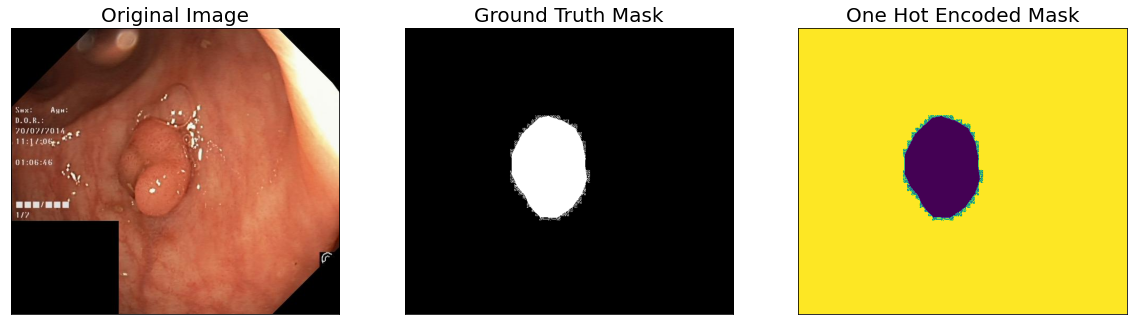

In [ ]:
dataset = EndoscopyDataset(train_df, class_rgb_values=select_class_rgb_values)
random_idx = random.randint(0, len(dataset)-1)
image, mask = dataset[0]

visualize(
    original_image = image,
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
    one_hot_encoded_mask = reverse_one_hot(mask)
)

### Defining Augmentations

In [ ]:
def get_training_augmentation():
    train_transform = [
        album.Resize(height=512, width=608, interpolation=cv2.INTER_CUBIC, always_apply=True),
        album.HorizontalFlip(p=0.5),
        album.VerticalFlip(p=0.5),
    ]
    return album.Compose(train_transform)


def get_validation_augmentation():
    # Add sufficient padding to ensure image is divisible by 32
    test_transform = [
        album.Resize(height=512, width=608, interpolation=cv2.INTER_CUBIC, always_apply=True),
    ]
    return album.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn=None):
    """Construct preprocessing transform
    Args:
        preprocessing_fn (callable): data normalization function
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    """
    _transform = []
    if preprocessing_fn:
        _transform.append(album.Lambda(image=preprocessing_fn))
    _transform.append(album.Lambda(image=to_tensor, mask=to_tensor))

    return album.Compose(_transform)

#### Visualize Augmented Images & Masks

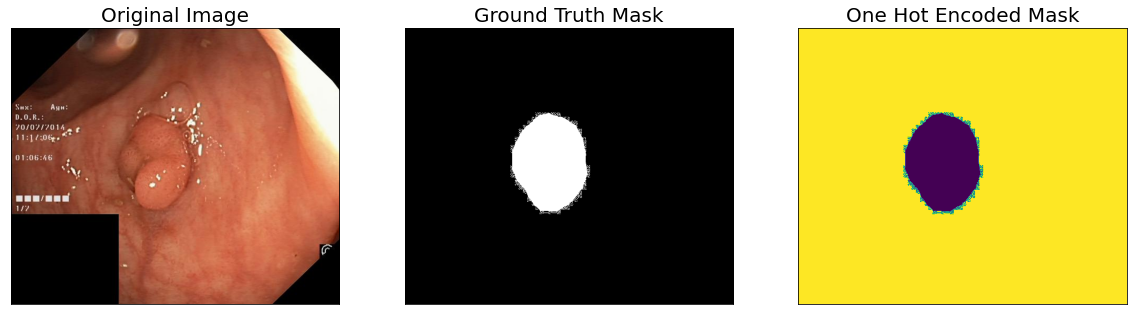

In [ ]:
augmented_dataset = EndoscopyDataset(
    train_df,
    augmentation=get_training_augmentation(),
    class_rgb_values=select_class_rgb_values,
)

random_idx = random.randint(0, len(augmented_dataset)-1)

# Different augmentations on image/mask pairs
for idx in range(1):
    image, mask = augmented_dataset[idx]
    visualize(
        original_image = image,
        ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
        one_hot_encoded_mask = reverse_one_hot(mask)
    )

### Model Definition

In [ ]:
ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = select_classes
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation

# create segmentation model with pretrained encoder
model = smp.Unet(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=len(CLASSES),
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


#### Get Train / Val DataLoaders

In [ ]:
# Get train and val dataset instances
train_dataset = EndoscopyDataset(
    train_df,
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

valid_dataset = EndoscopyDataset(
    valid_df,
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

# Get train and val data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False, num_workers=4)

#### Set Hyperparams

In [ ]:
# Set flag to train the model or not. If set to 'False', only prediction is performed (using an older model checkpoint)
TRAINING = True

# Set num of epochs
EPOCHS = 20

# Set device: `cuda` or `cpu`
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define loss function
loss = smp.utils.losses.DiceLoss()

# define metrics
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

# define optimizer
optimizer = torch.optim.Adam([
    dict(params=model.parameters(), lr=0.0001),
])

# define learning rate scheduler (not used in this NB)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=1, T_mult=2, eta_min=5e-5,
)

# load best saved model checkpoint from previous commit (if present)
if os.path.exists('../input/kvasir-seg-polyp-segmentation-using-unet-pytorch/best_model.pth'):
    model = torch.load('../input/kvasir-seg-polyp-segmentation-using-unet-pytorch/best_model.pth', map_location=DEVICE)

In [ ]:
train_epoch = smp.utils.train.TrainEpoch(
    model,
    loss=loss,
    metrics=metrics,
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
    verbose=True,
)

### Training UNet

In [ ]:
%%time

if TRAINING:

    best_iou_score = 0.0
    train_logs_list, valid_logs_list = [], []

    for i in range(0, EPOCHS):

        # Perform training & validation
        print('\nEpoch: {}'.format(i))
        train_logs = train_epoch.run(train_loader)
        valid_logs = valid_epoch.run(valid_loader)
        train_logs_list.append(train_logs)
        valid_logs_list.append(valid_logs)

        # Save model if a better val IoU score is obtained
        if best_iou_score < valid_logs['iou_score']:
            best_iou_score = valid_logs['iou_score']
            torch.save(model, './best_model.pth')
            print('Model saved!')


Epoch: 0
valid: 100%|██████████| 7/7 [00:05<00:00,  1.25it/s, dice_loss - 0.1279, iou_score - 0.9063]
Model saved!

Epoch: 1
valid: 100%|██████████| 7/7 [00:06<00:00,  1.09it/s, dice_loss - 0.1271, iou_score - 0.9085]
Model saved!

Epoch: 2
valid: 100%|██████████| 7/7 [00:06<00:00,  1.06it/s, dice_loss - 0.1277, iou_score - 0.9069]

Epoch: 3
valid: 100%|██████████| 7/7 [00:05<00:00,  1.18it/s, dice_loss - 0.1267, iou_score - 0.9093]
Model saved!

Epoch: 4
valid: 100%|██████████| 7/7 [00:05<00:00,  1.32it/s, dice_loss - 0.1276, iou_score - 0.9083]

Epoch: 5
valid: 100%|██████████| 7/7 [00:05<00:00,  1.32it/s, dice_loss - 0.128, iou_score - 0.9065]

Epoch: 6
valid: 100%|██████████| 7/7 [00:05<00:00,  1.22it/s, dice_loss - 0.1274, iou_score - 0.9068]

Epoch: 7
valid: 100%|██████████| 7/7 [00:05<00:00,  1.20it/s, dice_loss - 0.1272, iou_score - 0.9076]

Epoch: 8
valid: 100%|██████████| 7/7 [00:05<00:00,  1.29it/s, dice_loss - 0.1269, iou_score - 0.9087]

Epoch: 9
valid: 100%|██████████| 7

### Plot Dice Loss & IoU Metric for Train vs. Val

In [ ]:
train_logs_df = pd.DataFrame(train_logs_list)
valid_logs_df = pd.DataFrame(valid_logs_list)
train_logs_df.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
dice_loss,0.127713,0.127216,0.127377,0.128360,0.126692,0.128063,0.127970,0.128250,0.129677,0.128717,0.129461,0.127826,0.127289,0.128304,0.128167,0.127593,0.127770,0.126766,0.128317,0.129237
iou_score,0.908270,0.909699,0.908926,0.907056,0.910625,0.907883,0.908054,0.907531,0.903762,0.906311,0.904656,0.908376,0.909644,0.907101,0.907048,0.908336,0.907691,0.910444,0.907289,0.904961


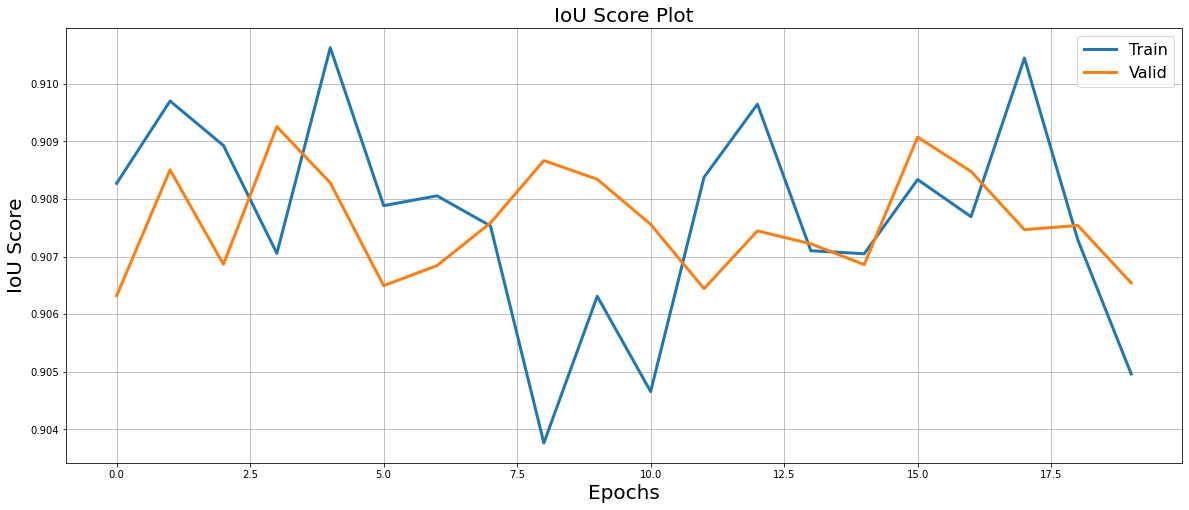

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(train_logs_df.index.tolist(), train_logs_df.iou_score.tolist(), lw=3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.iou_score.tolist(), lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('IoU Score', fontsize=20)
plt.title('IoU Score Plot', fontsize=20)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig('iou_score_plot.png')
plt.show()

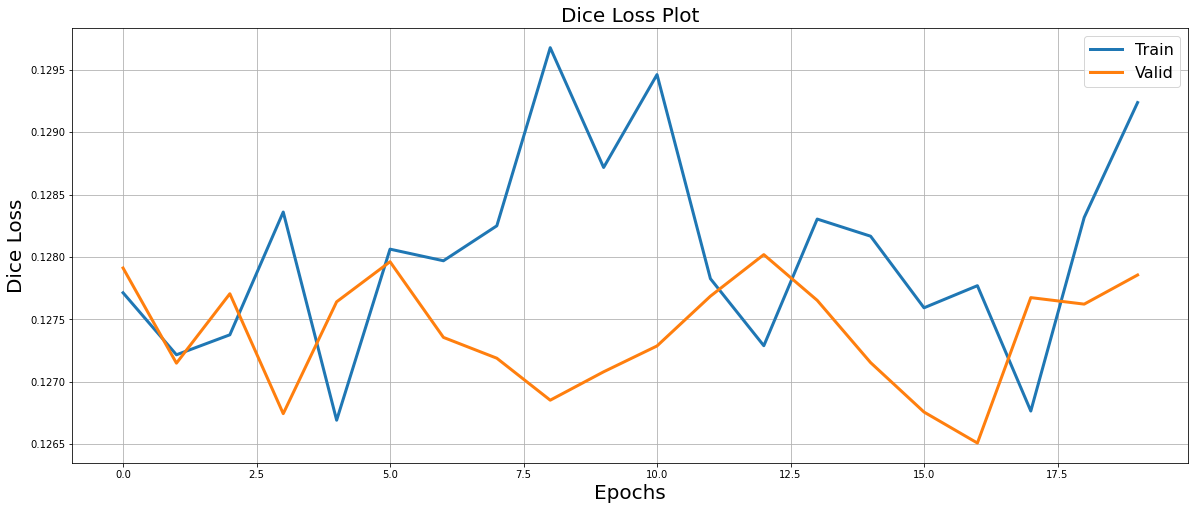

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(train_logs_df.index.tolist(), train_logs_df.dice_loss.tolist(), lw=3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.dice_loss.tolist(), lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Dice Loss', fontsize=20)
plt.title('Dice Loss Plot', fontsize=20)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig('dice_loss_plot.png')
plt.show()